<a href="https://colab.research.google.com/github/kuan0808/Med_Conversation_NER/blob/master/medical_NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ver3.2
####Chang  log:
- Class 包裝
- tag改用資料集中的tag總數
- 輸出csv檔


In [ ]:
import os
import numpy as np
import pandas as pd

import keras
from keras.models import Sequential
from keras.layers import Embedding, \
    GRU, Dense, TimeDistributed, Bidirectional, SpatialDropout1D
from keras.models import Model, Input
from keras.utils import plot_model, to_categorical
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

import datetime

import jieba
import jieba.posseg as pseg

from sklearn.model_selection \
    import train_test_split

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


#### teat

In [ ]:
# a = '我是，潘、冠廷......，我是一萬個感恩1234：；:,.、惜福99%，~～12.6%。'
# words = pseg.cut(a)
# print([(word, flag) for word, flag in words])
# print([word for word, flag in words if flag != 'x' and word != '......'])

In [ ]:
train_file_path = '/content/gdrive/My Drive/Colab Notebooks/data/train_1_update.txt'
test_file_path = '/content/gdrive/My Drive/Colab Notebooks/data/SampleData_deid.txt'
os.path.isfile(train_file_path)
os.path.isfile(test_file_path)

True

##  資料預處理

In [ ]:
def preprocess(path, is_train = True):
    content_list = []
    label_list = []
    with open(path, 'r', encoding='utf8') as f:
        raw_data=f.read().encode('utf-8').decode('utf-8-sig')
    articles = raw_data.split('\n\n--------------------\n\n')[:-1]
    for article in articles:
        label_tmp = []
        content = article.split('\n')[0]
        content.replace(' ', '')
        content_list.append(content)
        if is_train:
            for labels in article.split('\n')[2:]:
                label = labels.split('\t')
                label_tmp.append([int(label[1]), int(label[2]), label[4]])
            label_list.append(label_tmp)
    if is_train:
        return content_list, label_list
    return content_list

#### test

In [ ]:
content_list, label_list = preprocess(train_file_path)

print(label_list[-1])

[[33, 36, 'time'], [173, 176, 'time'], [203, 206, 'time'], [222, 226, 'time'], [331, 333, 'time'], [343, 347, 'time'], [378, 380, 'name'], [477, 480, 'time'], [589, 591, 'location'], [593, 595, 'location'], [1075, 1079, 'time'], [1083, 1084, 'time'], [1085, 1086, 'time'], [1087, 1089, 'time'], [1096, 1100, 'time'], [1123, 1125, 'location'], [1128, 1130, 'location'], [1136, 1138, 'location'], [1143, 1145, 'location'], [1173, 1177, 'location'], [1216, 1221, 'name'], [1250, 1255, 'name']]


## Jieba分詞

In [ ]:
def jieba_tokenizer(content_list):
    syntax = ['，', '。', '!', '?', ':', '！', '？', '：', '......', '；', '、', '~', '～', '%', '％']
    word_pos_list = []
    tokenized_content_list = []
    for content in content_list:
        tokenized_content_list_tmp = []
        word_pos_list_tmp = []
        result = jieba.tokenize(content)
        # words = pseg.cut(content)
        # tokenized_content_list_tmp = [word for word, flag in words if (flag != 'x' & word != '......')]
        for word, start, end in result:
            if word not in syntax:
                # try:
                #     num = int(word)
                #     word = '10'
                # except:
                    tokenized_content_list_tmp.append(word)
                    word_pos_list_tmp.append([start, end])

        tokenized_content_list.append(tokenized_content_list_tmp)

        word_pos_list.append(word_pos_list_tmp)
    
    return tokenized_content_list, word_pos_list

### test

In [ ]:
# tokenized_content_list, word_pos_list = jieba_tokenizer(content_list)
# print(tokenized_content_list)

##  Pre_train Embedding layer

In [ ]:
##                  ##
##借用別人的pretrain##
##                  ##
dim = 0
word_vecs= {}
# open pretrained word vector file
with open('/content/gdrive/My Drive/Colab Notebooks/Competition_med/cna.cbow.cwe_p.tar_g.512d.0.txt') as f:
    for line in f:
        tokens = line.strip().split()

        # there 2 integers in the first line: vocabulary_size, word_vector_dim
        if len(tokens) == 2:
            dim = int(tokens[1])
            continue
    
        word = tokens[0] 
        vec = np.array([ float(t) for t in tokens[1:] ])
        word_vecs[word] = vec

## 轉換詞向量

In [ ]:
def word_to_vector(tokenized_content_list, embedding_dict):
    embedded_list = []

    unk_vector = np.random.rand(*(list(embedding_dict.values())[0].shape))
    for idx in range(len(tokenized_content_list)):
        embedded_list_tmp = []
        for word in tokenized_content_list[idx]:
            if word in embedding_dict.keys():
                embedded_word = embedding_dict[word]
            else:
                embedded_word = unk_vector
                
#             value = embedding_dict.get(word)
#             print(value)
#             if value:
#                 embedded_word = value
#             else:
#                 embedded_word = unk_vector
            embedded_list_tmp.append(embedded_word)
        embedded_list.append(embedded_list_tmp)
    embedded_list = list(map(lambda x: np.array(x, dtype=np.float32), embedded_list))
    return embedded_list

#### test

In [ ]:
# for label in label_list[2]:
#     print(label)

## Dataset萃取

In [ ]:
class Data_getter():
    def __init__(self, file_path, is_train=True):
        self.file_path = file_path
        self.is_train = is_train
        if self.is_train:
            self.content_list, self.label_list = preprocess(self.file_path, self.is_train)
        else:
            self.content_list = preprocess(self.file_path, self.is_train)
        self.tokenized_content_list, self.word_pos_list = \
                            jieba_tokenizer(self.content_list)
        self.tags_list = self.preprocess_tags()
        self.max_len = max(len(tags_list) for tags_list in self.tags_list)
        self.num_tags = 0
        self.tag2idx = self.get_label_dict()
        self.X = self.get_X()
        self.y = self.get_y()  
                             
    def get_label_dict(self):
        merged_y = []
        for i in range(len(self.tags_list)):
            merged_y += self.tags_list[i]
        tags = list(set(merged_y))
        self.num_tags = len(tags)
        tag2idx = { t: i for i,t in enumerate(tags)}

        return tag2idx
    
    def preprocess_tags(self):
        tags_list = []
        print(len(self.tokenized_content_list))
        print(len(self.label_list))
        for i in range(len(self.tokenized_content_list)):
            tags_tmp = []
            for j in range(len(self.tokenized_content_list[i])):
                time_stamp = self.word_pos_list[i][j]
                count = 0
                for label in self.label_list[i]:
                    if time_stamp[0] >= label[0] and time_stamp[1] <= label[1]:
                        # if time_stamp[0] == label[0]:
                        #     tags_tmp.append('B-'+label[2])
                        # else:
                        #     tags_tmp.append('I-'+label[2])
                        tags_tmp.append(label[2])
                        count += 1
                        break
                if count == 0:
                    tags_tmp.append('O')
            tags_list.append(tags_tmp)
        return tags_list

    def get_y(self, tag2idx_dic=None):
        if tag2idx_dic:
            y = [[tag2idx_dic[w] for w in s]for s in self.tags_list]
            categor_method = lambda x: to_categorical(x)
            y = [to_categorical(i, num_classes=len(tag2idx_dic)) for i in y]
        else:
            y = [[self.tag2idx[w] for w in s]for s in self.tags_list]
            categor_method = lambda x: to_categorical(x)
            y = [to_categorical(i, num_classes=self.num_tags) for i in y]

        return y

    def get_X(self):
        X = word_to_vector(self.tokenized_content_list, word_vecs)
        
        return X
    
    def plot_sequence_length(self):
        plt.style.use("ggplot")
        plt.hist([len(s) for s in self.tokenized_content_list], bins=50)
        plt.show()

    @staticmethod
    def train_valid_split(X, y, validation_ratio, random_state=42):
        X_train, X_val, y_train, y_val = train_test_split(X, \
                    y,test_size=validation_ratio, random_state=random_state)
        
        return X_train, X_val, y_train, y_val

In [ ]:
trainset = Data_getter(train_file_path)
tag2idx = trainset.tag2idx
idx2tag = {v:k for k, v in tag2idx.items()}
num_tags = len(tag2idx)
x_train, y_train = trainset.X, trainset.y

testset = Data_getter(test_file_path)
x_test, y_test = testset.X, testset.get_y(tag2idx)
print(len(x_train[3]))
print(len(y_train[3]))

120
120
26
26
635
635


In [ ]:
# label_to_index = {}


# def get_label_dic(y):
#     merged_y = []
#     for i in range(len(y)):
#         merged_y += y[i]
#     labels = list(set(merged_y))

#     global label_to_index 
#     label_to_index  = {l : i for i, l in enumerate(labels)}

    
# def train_dataset(path, word_vecs, validation_ratio=0.1, random_state=42, valid=True):
#     y_train = []
#     content_list, label_list = preprocess(path)
#     tokenized_content_list, word_pos_list = jieba_tokenizer(content_list)
#     x_train = word_to_vector(tokenized_content_list, word_vecs) #未確定
    
#     for i in range(len(tokenized_content_list)):
#         y_train_tmp = []
#         for j in range(len(tokenized_content_list[i])):
#             time_stamp = word_pos_list[i][j]
#             count = 0
#             for label in label_list[i]:
#                 if time_stamp[0] >= label[0] and time_stamp[1] <= label[1]:
#                     y_train_tmp.append(label[2])
#                     count += 1
#                     break
#             if count == 0:
#                 y_train_tmp.append('O')
#         y_train.append(y_train_tmp)
#     get_label_dic(y_train)
#     y_train = [[label_to_index[l] for l in s] for s in y_train]
#     categor_method = lambda x: keras.utils.to_categorical(x, num_classes=len(label_to_index))
#     y_train = [categor_method(y).astype(np.float32) for y in y_train]    
#     if valid:
#         x_train, x_val, y_train, y_val = train_test_split(x_train, \
#                     y_train,test_size=validation_ratio, random_state=random_state)
#         return x_train, x_val, y_train, y_val
    
#     return x_train, y_train



#### test

In [ ]:
# def test_dataset(path, word_vecs):
#     content_list, label_list = preprocess(path)
#     tokenized_content_list, word_pos_list = jieba_tokenizer(content_list)
#     x_test = word_to_vector(tokenized_content_list, word_vecs)

#     return x_test, word_pos_list, content_list

#### test

In [ ]:
# x_test, word_pos_list, content_list = test_dataset(test_file_path, word_vecs)
# x_train, x_val, y_train, y_val = train_dataset(train_file_path, word_vecs, 0.1)
# index_to_label = {v: k for k, v in label_to_index.items()}
# num_labels = len(label_to_index)
# print(num_labels)
# print(len(x_test[1]))
# print(len(y_test[1]))

In [ ]:
# print(y_train[10])
# print(x_train[1].shape)
# for i in range(len(x_train)):
#     print(len(x_train[i]) == len(y_train[i]))

# Model建立

## Bidirectional GRU

In [ ]:
input_word = Input(shape = (None, 512))
model = SpatialDropout1D(0.1)(input_word)
model = Bidirectional(GRU(units = 128,return_sequences=True,recurrent_dropout = 0.1))(model)
out = TimeDistributed(Dense(num_tags, activation ='softmax'))(model)
model = Model(input_word,out)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, 512)]       0         
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, None, 512)         0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 256)         493056    
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 13)          3341      
Total params: 496,397
Trainable params: 496,397
Non-trainable params: 0
_________________________________________________________________


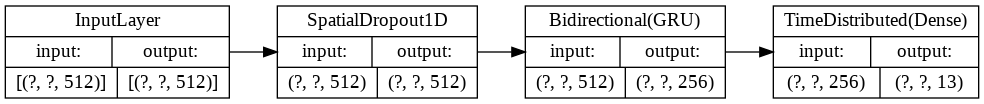

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

plot_model(
    model, 
    to_file='model.png', 
    show_shapes=True, 
    show_layer_names=False, 
    rankdir='LR')

## Data Generator

In [ ]:
def train_generator(x, y):
    while True:
        index = np.random.randint(len(x))
        Xb = np.expand_dims(x[index], axis=0)
        yb = np.expand_dims(y[index], axis=0)
        for i in range(len(x)):
            if (0 <= len(x[i]) - len(x[index]) <= 200) & (i != index):
                x_tmp = np.expand_dims(x[i][:len(x[index])], axis=0)
                y_tmp = np.expand_dims(y[i][:len(y[index])], axis=0)
                Xb = np.append(x_tmp, Xb, 0)
                yb = np.append(y_tmp, yb, 0)
        yield (Xb, yb)

In [ ]:
history = model.fit(train_generator(x_train, y_train), steps_per_epoch=50, epochs=10, verbose=1)

Epoch 1/10
50/50 [==============================] - 472s 9s/step - loss: 0.1990 - accuracy: 0.9516
Epoch 2/10
50/50 [==============================] - 411s 8s/step - loss: 0.0620 - accuracy: 0.9831
Epoch 3/10
50/50 [==============================] - 385s 8s/step - loss: 0.0476 - accuracy: 0.9859
Epoch 4/10
50/50 [==============================] - 440s 9s/step - loss: 0.0418 - accuracy: 0.9875
Epoch 5/10
50/50 [==============================] - 422s 8s/step - loss: 0.0365 - accuracy: 0.9886
Epoch 6/10
50/50 [==============================] - 426s 9s/step - loss: 0.0304 - accuracy: 0.9905
Epoch 7/10
50/50 [==============================] - 432s 9s/step - loss: 0.0262 - accuracy: 0.9918
Epoch 8/10
50/50 [==============================] - 419s 8s/step - loss: 0.0226 - accuracy: 0.9929
Epoch 9/10
50/50 [==============================] - 420s 8s/step - loss: 0.0187 - accuracy: 0.9944
Epoch 10/10
50/50 [==============================] - 368s 7s/step - loss: 0.0147 - accuracy: 0.9957


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Accuracy Curves')

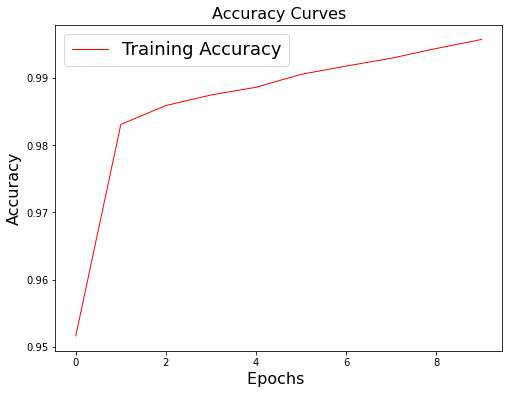

In [ ]:
#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=1.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

Text(0.5, 1.0, 'Loss Curves')

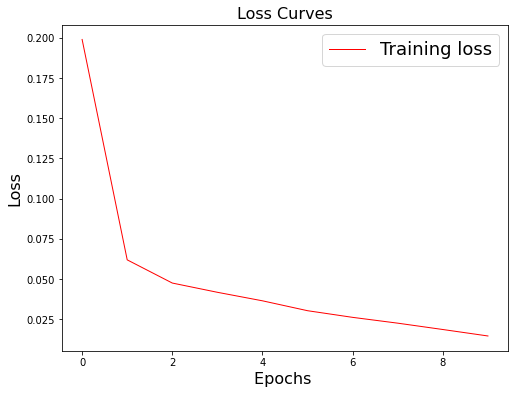

In [ ]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=1.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

In [ ]:
model.save('/content/gdrive/My Drive/Colab Notebooks/Competition_med/BiGRU_ver3-2.model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/Competition_med/BiGRU_ver3-2.model/assets


## Load in trained Model

In [ ]:
model = keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/Competition_med/BiGRU_ver3-2.model')

## Model Evaluate

In [ ]:
total_num =  0
correct_num = 0

In [ ]:
def comparison(article_id, y_pred, y_true, path):
     with open(path, 'a') as f:
        f.write('article_id\ty_pred\ty_true\n')
        f.write('-'*30+'\n')
        y_pred = np.squeeze(y_pred)
        y_pred = [np.argmax(y) for y in y_pred]
        y_true = [np.argmax(y) for y in y_true]
        for i in range(len(y_pred)):
            if not (idx2tag[y_true[i]] == 'O' and idx2tag[y_pred[i]] == 'O'):
                global total_num
                total_num += 1
                f.write(f'{article_id}\t{idx2tag[y_pred[i]]}\t{idx2tag[y_true[i]]}\n')
                if idx2tag[y_true[i]] == idx2tag[y_pred[i]]:
                    global correct_num
                    correct_num += 1

In [ ]:
def check_merge(label_list):
    merged_label_list = []
    index = 0
    flag = 0
    def bool(idx, flg):
        try:
            f = (label_list[idx+flg][2] == label_list[idx+flg+1][2]) & \
                    (label_list[idx+flg][1]+1 >= label_list[idx+flg+1][0])
            return f
        except:
            return False
    while index <= len(label_list)-1:
        if bool(index, flag):
            flag += 1
        else:
            [start, end] = [label_list[index][0], label_list[index+flag][1]]
            merged_label_list.append([start, end, label_list[index][2]])
            index = index + flag + 1
            flag = 0
    return merged_label_list

In [ ]:
category_list = []
output = 'article_id\tstart\tend\tentity_word\tentitytype\n'
for article_id in range(len(x_test)):
    y_pred = model.predict(x_test[article_id].reshape(1, *x_test[article_id].shape))
    comparison(article_id, y_pred, y_test[article_id],'/content/gdrive/My Drive/Colab Notebooks/Competition_med/comparison.txt')

    category_list_tmp = []
    for y in np.squeeze(y_pred):
        category = np.argmax(y)
        category = idx2tag[category]
        category_list_tmp.append(category)
    label_info = []
    for i in range(len(category_list_tmp)):
        label = category_list_tmp[i]
        if label != 'O':
            stamp = testset.word_pos_list[article_id][i]
            label_info.append([stamp[0], stamp[1], label])
    label_info = check_merge(label_info)
    for i in range(len(label_info)):
        output = output + f'{article_id}\t{label_info[i][0]}\t{label_info[i][1]}\t{testset.content_list[article_id][label_info[i][0]:label_info[i][1]]}\t{label_info[i][2]}\n'
    category_list.append(label_info) 

In [ ]:
accuracy = correct_num / total_num
accuracy

0.5945945945945946

In [ ]:
with open('/content/gdrive/My Drive/Colab Notebooks/output3_2_1.txt', 'w') as fw:
    fw.write(output)
df = pd.read_table('/content/gdrive/My Drive/Colab Notebooks/output3_2_1.txt')
pd.set_option('display.max_rows', 10000)
df

,article_id,start,end,entity_word,entitytype
0,0,66,68,68,med_exam
1,0,1376,1378,醫院,location
2,0,1863,1865,十天,time
3,0,2604,2609,3月18號,time
4,0,2613,2616,下禮拜,time
5,0,2622,2625,下禮拜,time
6,0,2630,2635,3月24日,time
7,0,2650,2652,3月,time
8,0,2654,2656,醫院,location
9,0,2663,2672,禮拜二到禮拜四其中,time


In [ ]:
df.to_csv('/content/gdrive/My Drive/Colab Notebooks/output3_2_1.csv')